# Image classification with Vision Transformer
This example implements for image classification,and demonstrates it on the CIFAR-10 and CIFAR-100 datasetS.
The HYBRID MODEL consists of a modified ViT and attentive modules.

**!pip install -U tensorflow-addons**


# LIBRARIES


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10,cifar100
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import time
from keras.applications.nasnet import NASNetMobile, preprocess_input
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from __future__ import print_function, division, absolute_import
import timeit
import numpy as np
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D,UpSampling2D,Conv2DTranspose,DepthwiseConv2D,Conv1D,Add
from tensorflow.keras.layers import ELU,SeparableConv2D,DepthwiseConv1D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense,ZeroPadding2D,Concatenate,AveragePooling1D
from tensorflow.keras.optimizers import RMSprop, SGD, Adam,Adadelta,Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from keras.models import load_model
import os
from PIL import Image
import requests
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import matplotlib.pyplot as plt
from keras.activations import *
from tensorflow.python.keras.utils.generic_utils import deserialize_keras_object
from tensorflow.python.keras.utils.generic_utils import serialize_keras_object
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from numpy.core.fromnumeric import transpose
import math

#Load data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

train_lab_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')
test_lab_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='uint8')

from sklearn.model_selection import train_test_split

train_im, valid_im, train_lab, valid_lab = train_test_split(x_train, train_lab_categorical, test_size=0.20,
                                                            stratify=train_lab_categorical,
                                                            random_state=40, shuffle = True)

training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab))
validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab))
#test_data = tf.data.Dataset.from_tensor_slices((x_test, test_lab_categorical))




train_data = training_data.shuffle(buffer_size=50000).batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_data = validation_data.shuffle(buffer_size=10000).batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#test_data = test_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

170498071/170498071 [==============================] - 11s 0us/step


In [ ]:
rescale_layer_cnn = tf.keras.layers.Rescaling(1./127.5,offset=-1)
rescale_layer_vit = tf.keras.layers.Rescaling(1./127.5,offset=-1)

rescale_resize_vit = tf.keras.layers.experimental.preprocessing.Resizing(224,224, interpolation="lanczos5")
rescale_resize_cnn = tf.keras.layers.experimental.preprocessing.Resizing(224,224, interpolation="lanczos5")

data_augmentation_cnn = tf.keras.Sequential([
  #layers.experimental.preprocessing.RandomFlip("horizontal"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
  #layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  #layers.experimental.preprocessing.RandomTranslation(0.0, 0.0, fill_mode='reflect', interpolation='bilinear',)
])

data_augmentation_vit = tf.keras.Sequential([
  #layers.experimental.preprocessing.RandomFlip("horizontal"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
  #layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  #layers.experimental.preprocessing.RandomTranslation(0.0, 0.0, fill_mode='reflect', interpolation='bilinear',)
])

## Labe Encoding

In [ ]:
y_train = tf.cast(y_train,tf.int32)
y_test = tf.cast(y_test,tf.int32)
y_train = tf.one_hot(y_train,depth=10)
y_test = tf.one_hot(y_test, depth=10)
y_train = tf.cast(y_train,tf.float32)
y_test = tf.cast(y_test,tf.float32)

## Lr warm up

In [ ]:
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

import random
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )
    def get_config(self):
        config = {
                'learning_rate_base': self.learning_rate_base,
                'total_steps': self.total_steps,
                'warmup_learning_rate': self.warmup_learning_rate,
                'warmup_steps': self.warmup_steps,

                 }
        return config

In [ ]:
EPOCHS = 50
TOTAL_STEPS = int((50000 / BATCH_SIZE) * EPOCHS)
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

print(TOTAL_STEPS)

39062


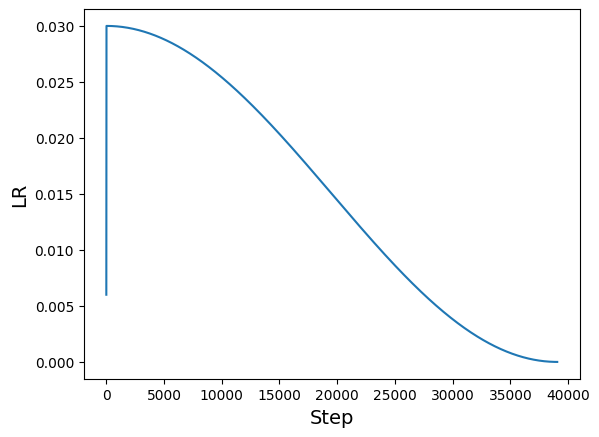

In [ ]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# hyperparameter setting

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_classes=10
batch_size = 64
num_epochs = 100
image_size = 224  # We'll resize input images to this size
patch_size = 64 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers =2
mlp_head_units = [2048,1024]  # Size of the dense layers of the final classifier

## data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        #layers.Normalization(),
        layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
         #   height_factor=0.2, width_factor=0.2
        #),
    ],
    name="data_augmentation",
)


## Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## patch encoding layer


In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
##############
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        ) #produce a table to map inputs to embedding vectors

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded




# Bottlneck_Channelmix Functions


In [ ]:
def channel_mix(l,imgs):

    channel_r=imgs[:,:,0:1]
    channel_g=imgs[:,:,1:2]
    channel_b=imgs[:,:,2:3]

    channel1_r=l[:,:,0:21]
    channel1_g=l[:,:,21:41]
    channel1_b=l[:,:,43:63]

    l1 = tf.concat([channel1_r, channel_r],axis=2)
    l2 = tf.concat([channel1_g, channel_g],axis=2)
    l3 = tf.concat([channel1_b, channel_b],axis=2)

    l = tf.concat([l1,l2,l3],axis=2)

    return l

In [ ]:

def bottleneck(input,layers):
    for _ in range(layers):
        print("INPUT SHAPE",input.shape)
        x=Conv1D(64, 5, padding = "same", kernel_initializer="he_normal")(input)
        x=Activation('elu')(x)
        print("First CONV SHAPE ",x.shape)
        x2= DepthwiseConv1D( 1, padding = 'same', kernel_initializer="he_normal",depth_multiplier=2)(input)
        print("input increased dimension Shape",x2.shape)
        x = Add()([input,x])
        x=Conv1D(64, 1, padding = "same", groups=4 , kernel_initializer="he_normal")(x)
        x=Activation('elu')(x)
        print("Decreased dimension shape",x.shape)
        x= channel_mix (x, input)
        print("OUTPUT x SHAPE",x.shape)
        return x

In [ ]:
#@under_name_scope()
def channel_shuffle(l, group):
    in_shape = l.get_shape().as_list()
    in_channel = in_shape[2]
    assert in_channel % group == 0, in_channel
    l = tf.reshape(l, [-1, in_channel // group, group] + in_shape[-1:])
    l = tf.transpose(l, [0, 2, 1, 3])
    l = tf.reshape(l, [-1, in_channel] + in_shape[-1:])
    print('shuffle output',l.shape)
    return l


In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
handle="https://tfhub.dev/sayakpaul/vit_s16_fe/1"
b1_vit="https://tfhub.dev/sayakpaul/vit_b8_classification/1"
mixer_1 = "https://tfhub.dev/sayakpaul/mixer_b16_sam_classification/1"
feature_extractor_model = mixer_1
mixer_2 = "https://tfhub.dev/sayakpaul/mixer_b16_sam_fe/1"
feature_extractor_model2 = mixer_2



# Modified Vit

In [ ]:
inputs_primary = layers.Input(shape=(32,32, 3))

inputs_vit_rescaled=rescale_layer_vit (inputs_primary)
inputs_vit_resized = rescale_resize_vit (inputs_vit_rescaled)
print (inputs_vit_resized.shape)
input_augmented_vit = data_augmentation_vit (inputs_vit_resized)

#################################

mixer_3 = "https://tfhub.dev/sayakpaul/vit_b8_classification/1"
feature_extractor_model2 = mixer_3
feature_extractor_layer = hub.KerasLayer(feature_extractor_model2,input_shape=(224,224 ,3),trainable=False)
augmented1 = feature_extractor_layer(input_augmented_vit)
print('feature_extractor output:',augmented1.shape)
augmented12 = tf.expand_dims(augmented1, axis=1)
print('12:',augmented12.shape)
augmented13 = tf.expand_dims(augmented12, axis=2)
print('13:',augmented13.shape)
#######################################################
# Create patches.
patches = Patches(patch_size)(augmented13)
# Encode patches.
print(' patches:',patches.shape)
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
print(' encoded_patches output :',encoded_patches.shape)

for _ in range(transformer_layers):
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.0
    )(encoded_patches, encoded_patches)

    # Bottlneck for odd layers
    if _  <= (1):
       attention_output = bottleneck(attention_output,1)

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # MLP.
    x3 = mlp(x2, hidden_units=transformer_units, dropout_rate=0.0)

    # Skip connection 2.
    encoded_patches = layers.Add()([x3, x2])

    ##################
representation2 = layers.Flatten()(encoded_patches)
representation = layers.Dropout(0.2)(representation2)
# Add MLP.
features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.0)
model_vit = Model(inputs=inputs_primary, outputs=features)

(None, 224, 224, 3)
feature_extractor output: (None, 1000)
12: (None, 1, 1000)
13: (None, 1, 1, 1000)
 patches: (None, None, 4096000)
 encoded_patches output : (None, 9, 64)
INPUT SHAPE (None, 9, 64)
First CONV SHAPE  (None, 9, 64)
input increased dimension Shape (None, 9, 128)
Decreased dimension shape (None, 9, 64)
OUTPUT x SHAPE (None, 9, 64)
INPUT SHAPE (None, 9, 64)
First CONV SHAPE  (None, 9, 64)
input increased dimension Shape (None, 9, 128)
Decreased dimension shape (None, 9, 64)
OUTPUT x SHAPE (None, 9, 64)


# Attention Module 1

In [ ]:
# MODEL 0
inputs_primary = layers.Input(shape=(32,32, 3))
##########
inputs_cnn_rescaled=rescale_layer_cnn (inputs_primary)
inputs_cnn_resized = rescale_resize_cnn (inputs_cnn_rescaled)
print (inputs_cnn_resized.shape)
input_augmented_cnn = data_augmentation_cnn (inputs_cnn_resized)
###################################################################
mixer_32 = "https://tfhub.dev/sayakpaul/vit_b8_classification/1"
feature_extractor_model3 = mixer_32
feature_extractor_layer2 = hub.KerasLayer(feature_extractor_model3,input_shape=(224,224 ,3),trainable=False)
augmented123 = feature_extractor_layer2(input_augmented_cnn)
print('feature_extractor out:',augmented123.shape)
#############
augmented123=tf.expand_dims(augmented123,axis=2)
ave1 = AveragePooling1D(pool_size=(2), padding='valid', strides=2, name='Avg_pool_1')(augmented123)
print('pool first',ave1.shape)
ave2 = AveragePooling1D(pool_size=(3), padding='valid', strides=3, name='Avg_pool_2')(augmented123)
print('pool second',ave2.shape)
ave3 = AveragePooling1D(pool_size=(5), padding='valid', strides=5, name='Avg_pool_3')(augmented123)
print('pool third',ave3.shape)
ave_concate = Concatenate(axis=1) ([ave1,ave2,ave3])
print('ave_pool concate',ave_concate.shape)
max1 = AveragePooling1D(pool_size=(2), padding='valid', strides=2, name='max_pool_1')(augmented123)
print('max first',max1.shape)
max2 = AveragePooling1D(pool_size=(3), padding='valid', strides=3, name='max_pool_2')(augmented123)
print('max second',max2.shape)
max3 = AveragePooling1D(pool_size=(5), padding='valid', strides=5, name='max_pool_3')(augmented123)
print('max third',max3.shape)
max_concate = Concatenate(axis=1) ([max1,max2,max3])
print('max_pool concate',ave_concate.shape)
pool_con= Concatenate(axis=1) ([max_concate,ave_concate])
print('pool concate',pool_con.shape)
pool_flattend = Flatten()(pool_con)
print('pool flattend',pool_flattend.shape)
#####################################################################
s0, s1 = tf.split(pool_flattend, num_or_size_splits=2, axis=1)
print('split shape:',s0.shape)
a1=  tf.stack([s0, s1], axis=1)
print('concate shape:',a1.shape)
####################################
input_dec=Conv1D(500, (1), padding = "same", kernel_initializer="he_normal",name='decrease_dimension_1')(a1)
x1_branch=Conv1D(500, (3), padding = "same", kernel_initializer="he_normal",name='conv2D_1_module_1')(a1)
x1_branch=BatchNormalization()(x1_branch)
x1_branch_out = Activation("softmax", dtype=tf.float32, name="softmax_module_1")(x1_branch)
x1_out = tf.math.multiply(input_dec, x1_branch_out)
####################################
x2_branch=Conv1D(250, (1), padding = "same", kernel_initializer="he_normal",name='conv2D_2_module_1')(x1_out)
print(x2_branch.shape)
x2_branch=BatchNormalization()(x2_branch)
x2_branch=Activation('elu')(x2_branch)
x2_branch=DepthwiseConv1D(250, (1),padding='same', depth_multiplier=2, kernel_initializer="he_normal",name='conv2D_3_module_1')(x2_branch)
print(x2_branch.shape)
##########################
x2_out = x2_branch
z= tf.math.multiply(input_dec, x2_out)
model_1 = Model(inputs_primary, outputs=z)

(None, 224, 224, 3)
feature_extractor out: (None, 1000)
pool first (None, 500, 1)
pool second (None, 333, 1)
pool third (None, 200, 1)
ave_pool concate (None, 1033, 1)
max first (None, 500, 1)
max second (None, 333, 1)
max third (None, 200, 1)
max_pool concate (None, 1033, 1)
pool concate (None, 2066, 1)
pool flattend (None, 2066)
split shape: (None, 1033)
concate shape: (None, 2, 1033)
(None, 2, 250)
(None, 2, 500)


# Attention Module 2

In [ ]:
inputs_primary = layers.Input(shape=(32,32, 3))
##########
inputs_cnn_rescaled=rescale_layer_cnn (inputs_primary)
inputs_cnn_resized = rescale_resize_cnn (inputs_cnn_rescaled)
print (inputs_cnn_resized.shape)
mixer_35 = "https://tfhub.dev/sayakpaul/vit_b8_classification/1"
feature_extractor_model5 = mixer_35
feature_extractor_layer4 = hub.KerasLayer(feature_extractor_model5,input_shape=(224,224 ,3),trainable=False)
x_resi2 = feature_extractor_layer4(inputs_cnn_resized)
x_resi2=tf.dtypes.cast(x_resi2,tf.float32)
model_helper_1 = Model(inputs=inputs_primary, outputs=x_resi2)

(None, 224, 224, 3)


# Attention Module 3

In [ ]:
inputs_primary = layers.Input(shape=(32,32, 3))

inputs_vit_rescaled=rescale_layer_vit (inputs_primary)
inputs_vit_resized = rescale_resize_vit (inputs_vit_rescaled)
print (inputs_vit_resized.shape)
mixer_34 = "https://tfhub.dev/sayakpaul/vit_b8_classification/1"
feature_extractor_model4 = mixer_34
feature_extractor_layer3 = hub.KerasLayer(feature_extractor_model4,input_shape=(224,224 ,3),trainable=False)
x_resi2 = feature_extractor_layer3(inputs_vit_resized)
x_resi2=tf.dtypes.cast(x_resi2,tf.float32)
model_helper_2 = Model(inputs=inputs_primary, outputs=x_resi2)

(None, 224, 224, 3)


# Main Model

In [ ]:
models = [model_1,model_vit,model_helper_1,model_helper_2]

inputs_primary = layers.Input(shape=(32,32, 3))
model_1 = [model(inputs_primary) for model in models[0:1]]
model_vit = [model(inputs_primary) for model in models[1:2]]
model_helper_1 = [model(inputs_primary) for model in models[2:3]]
model_helper_2 = [model(inputs_primary) for model in models[3:4]]

x3c = tf.squeeze(model_helper_1, axis=[0])
x3c=tf.dtypes.cast(x3c,tf.float32)
x3c = Flatten()(x3c)
model_helper_1_out=tf.dtypes.cast(x3c,tf.float32)
x3 = tf.squeeze(model_1, axis=[0])
x3=tf.dtypes.cast(x3,tf.float32)
x3 = Flatten()(x3)
model_cnn_out=tf.dtypes.cast(x3,tf.float32)
model_cnn_out_concatenate = Concatenate(axis=-1) ([model_cnn_out,model_helper_1_out])
x2qx = Dense(64, activation='elu',name='dense2w')(model_cnn_out_concatenate)
x3qx =BatchNormalization()(x2qx)
x4qx = Dropout(0.2)(x3qx)
x_1qx = Dense(32, activation='elu',name='dense1w')(x4qx)
x_qx =BatchNormalization()(x_1qx)
xq = Dropout(0.2)(x_qx)
x_out = Dense(num_classes, dtype=tf.float32)(xq)
x72wx = Activation("softmax",name='model0')(x_out)
##################################################################
x3a = tf.squeeze(model_1, axis=[0])
x3a=tf.dtypes.cast(x3a,tf.float32)
x3a = Flatten()(x3a)
model_cnn_outa=tf.dtypes.cast(x3a,tf.float32)
model_cnn_out_concatenatea = Concatenate(axis=-1) ([model_cnn_out,model_helper_1_out])
model_cnn_out_concatenatea = Flatten() (model_cnn_out_concatenatea)
x2qxa = Dense(128, activation='elu',name='dense2w')(model_cnn_out_concatenatea)
x3qxa =BatchNormalization()(x2qx)
x4qxa = Dropout(0.2)(x3qx)
x7_1qxa = Dense(64, activation='elu',name='dense1w')(x4qxa)
x7_2qxa =BatchNormalization()(x7_1qxa)
x7qxa = Dropout(0.2)(x7_2qxa)
x71wxa = Dense(num_classes, dtype=tf.float32)(x7qxa)
x72wxa = Activation("softmax",name='model2')(x71wxa)
######Model helper 2
x3v = tf.squeeze(model_helper_2, axis=[0])
x3v=tf.dtypes.cast(x3v,tf.float32)
x3v = Flatten()(x3v)
model_helper_2_out=tf.dtypes.cast(x3v,tf.float32)
#################################
x3v = tf.squeeze(model_vit, axis=[0])
x3v=tf.dtypes.cast(x3v,tf.float32)
x3v = Flatten()(x3v)
model_vit_out=tf.dtypes.cast(x3,tf.float32)
model_vit_out_concatenate = Concatenate(axis=-1) ([model_vit_out,model_helper_2_out])
model_vit_out_concatenate = Flatten()(model_vit_out_concatenate)
x2 = Dense(64, activation='elu',name='dense_vit11')(model_vit_out_concatenate)
x3 =BatchNormalization()(x2)
x4v = Dropout(0.2)(x3)
x2v = Dense(32, activation='elu',name='dense_vit12')(x4v)
x3v =BatchNormalization()(x2v)
x4v = Dropout(0.2)(x3v)
x_v81 = layers.Dense(num_classes)(x4v)
x_v8 = Activation("softmax",name='vit')(x_v81)
#########################################
avr= tf.keras.layers.Average(name='average')([x_v8,x72wx])
model_final = Model(inputs=inputs_primary, outputs=[x_v8,x72wx,avr])

# Callback function

In [ ]:
# Create tensorboard callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback
#############################
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, #
                                                 min_lr=1e-7)

def decay(epochs, steps=100):
    initial_lrate = 0.0001
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+(2*epochs)/epochs_drop)))
    return lrate
################################
save_dir = os.path.join(os.getcwd(), "/save_model")
filepath = "vit_cnn_20apr.{epoch:02d}-{val_model0_accuracy:.4f}.tf"

checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(save_dir, filepath),
                             monitor="val_model0_accuracy",
                             save_best_only=True,
                             mode="max",
                             verbose=0)
##############################
lr_sc = LearningRateScheduler(decay,verbose=1)
mycallback = [early_stopping,lr_sc,reduce_lr,
              create_tensorboard_callback(dir_name="tensorflow_hub",
              experiment_name="ENSEMBLE Vit_Cnn_CIFAR10_Exp Apr20")]

Saving TensorBoard log files to: tensorflow_hub/ENSEMBLE Vit_Cnn_CIFAR10_Exp Apr20/20231209-000433


# TRAIN


## Donload weights from  [link text](https://drive.google.com/drive/folders/15sN8wzAYOH6XFQiAGzA2Zg13Ykb4QZad?usp=sharing)

In [ ]:
model_final.load_weights("/content/drive/MyDrive/CIFAR10/save_models/cifar10_hybrid_vit&cnn_model_weights_98.55%.tf")

## Compile & Train

In [ ]:
optimizer_adamax =Adamax(learning_rate=0.001)
lossWeights = {'model0':0.75,'vit':0.25,'average':2.0}
loss = keras.losses.CategoricalCrossentropy()

model_final.compile( optimizer=optimizer_adamax, metrics=["accuracy"],loss={'model0':loss,'vit':loss,'average':loss},loss_weights=lossWeights)
history = model_final.fit(train_data, epochs=50,validation_data=valid_data,batch_size=64,callbacks=[mycallback],workers=8)



Epoch 1: LearningRateScheduler setting learning rate to 9.6e-05.
Epoch 1/50
625/625 [==============================] - 797s 1s/step - loss: 0.1241 - vit_loss: 0.0460 - model0_loss: 0.0447 - average_loss: 0.0395 - vit_accuracy: 0.9870 - model0_accuracy: 0.9888 - average_accuracy: 0.9893 - val_loss: 0.1626 - val_vit_loss: 0.0532 - val_model0_loss: 0.0581 - val_average_loss: 0.0528 - val_vit_accuracy: 0.9838 - val_model0_accuracy: 0.9836 - val_average_accuracy: 0.9834 - lr: 9.6000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.6e-05.
Epoch 2/50
625/625 [==============================] - 785s 1s/step - loss: 0.1146 - vit_loss: 0.0422 - model0_loss: 0.0414 - average_loss: 0.0365 - vit_accuracy: 0.9883 - model0_accuracy: 0.9888 - average_accuracy: 0.9904 - val_loss: 0.1647 - val_vit_loss: 0.0543 - val_model0_loss: 0.0580 - val_average_loss: 0.0538 - val_vit_accuracy: 0.9838 - val_model0_accuracy: 0.9832 - val_average_accuracy: 0.9839 - lr: 9.6000e-05

Epoch 3: LearningRateSc